<h1><center> Machine Learning Engineering nano Degree </center></h1>
<h3><center>  Capstone Project - Rémi Ang </center></h3>

<h2><center>Flowers recognition</center></h2>

![Daisy](./images_samples/813445367_187ecf080a_n.jpg)

<a id="top"></a>

---

** Introduction **

This aim of this notebook is to define and train a Deep Convolutional Network able to recognize flower species based on a picture. 

The dataset is the ["Flowers Recognition"](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset from Kaggle donated by [Alexander Mamaev](https://www.kaggle.com/alxmamaev).

The dataset contains 4362 pictures devided in 5 classes: Daisy, Dandelion, Rose, Sunflower, Tulip 

---

**Notebook summary:**

* [Step 1](#step1) : Imports and print packages version
* [Step 2](#step2) : Scan the flowers pictures dataset
* [Step 3](#step3) : Visualize some pictures
* [Step 4](#step4) : Flowers classes distribution
* [Step 5](#step5) : stratified Train/test split the data and copy pictures in train/test folders
* [Step 6](#step6) : Data augmentation - create images generators
* [Step 7](#step7) : get the model

<a id="step1"></a>
## 1. imports
[to the top](#top)

In [126]:
# reload modules
import importlib

import custom_utils
importlib.reload(custom_utils)

from custom_utils import print_list, plot_images, flowersDistBarplot, copy_pictures

In [189]:
print("loading basic packages...")
import sys
import os
# set TensorFlow as Keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

#import glob
import urllib
import random
import itertools
from shutil import rmtree

from custom_utils import print_list, plot_images, flowersDistBarplot, copy_pictures

print("loading plotting packages...")
import matplotlib as mlp
%matplotlib inline  

import matplotlib.pyplot as plt
#plt.style.use('ggplot')

import seaborn as sns

print("loading Numpy...")
import numpy as np

print("loading Sklearn...")
from sklearn import __version__ as sklearn_version
from sklearn.datasets import load_files 

print("loading Keras...")
from keras import __version__ as keras_version
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
import keras.applications.xception as xception 
#from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3

from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint  

print("loading TensorFlow...")
from tensorflow import __version__ as tf_version

print("loading OpenCV...")
import cv2

# define random seed
random_seed = 6

loading basic packages...
loading plotting packages...
loading Numpy...
loading Sklearn...
loading Keras...
loading TensorFlow...
loading OpenCV...


In [120]:
# print packages version

print("Packages versions:")
print("------------------")
print("Python: {}".format(sys.version))
print("Matplotlib : {}".format(mlp.__version__))
print("Seaborn : {}".format(sns.__version__))
print("Numpy : {}".format(np.__version__))
print("Scikit-learn : {}".format(sklearn_version))
print("Keras : {}".format(keras_version))
print("Keras backend: {}".format(os.environ['KERAS_BACKEND']))
print("Tensor Flow : {}".format(tf_version))
print("openCV : {}".format(cv2.__version__))

Packages versions:
------------------
Python: 3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, 21:28:42) [MSC v.1900 64 bit (AMD64)]
Matplotlib : 2.2.2
Seaborn : 0.8.1
Numpy : 1.13.3
Scikit-learn : 0.19.0
Keras : 2.0.2
Keras backend: tensorflow
Tensor Flow : 1.8.0
openCV : 3.1.0


<a id="step2"></a>
## 2. Scan the flowers pictures dataset
[to the top](#top)

In [86]:
path = "./flowers/"

print("Collecting files from data folder : {}".format(path))
data = load_files(path, load_content=False)

flowers_files = np.array([s.replace('\\', '/') for s in data["filenames"]])
# flowers_targets = np_utils.to_categorical(data["target"],5)
flowers_targets = data["target"]
flowers_target_names = data["target_names"]

print("{} flower pictures found".format(flowers_files.shape[0]))
print_list(flowers_target_names, 'types of flower found')


4326 flower pictures found
5 types of flower found:
	o daisy
	o dandelion
	o rose
	o sunflower
	o tulip


<a id="step3"></a>
##  3. Visualize some pictures
[to the top](#top)

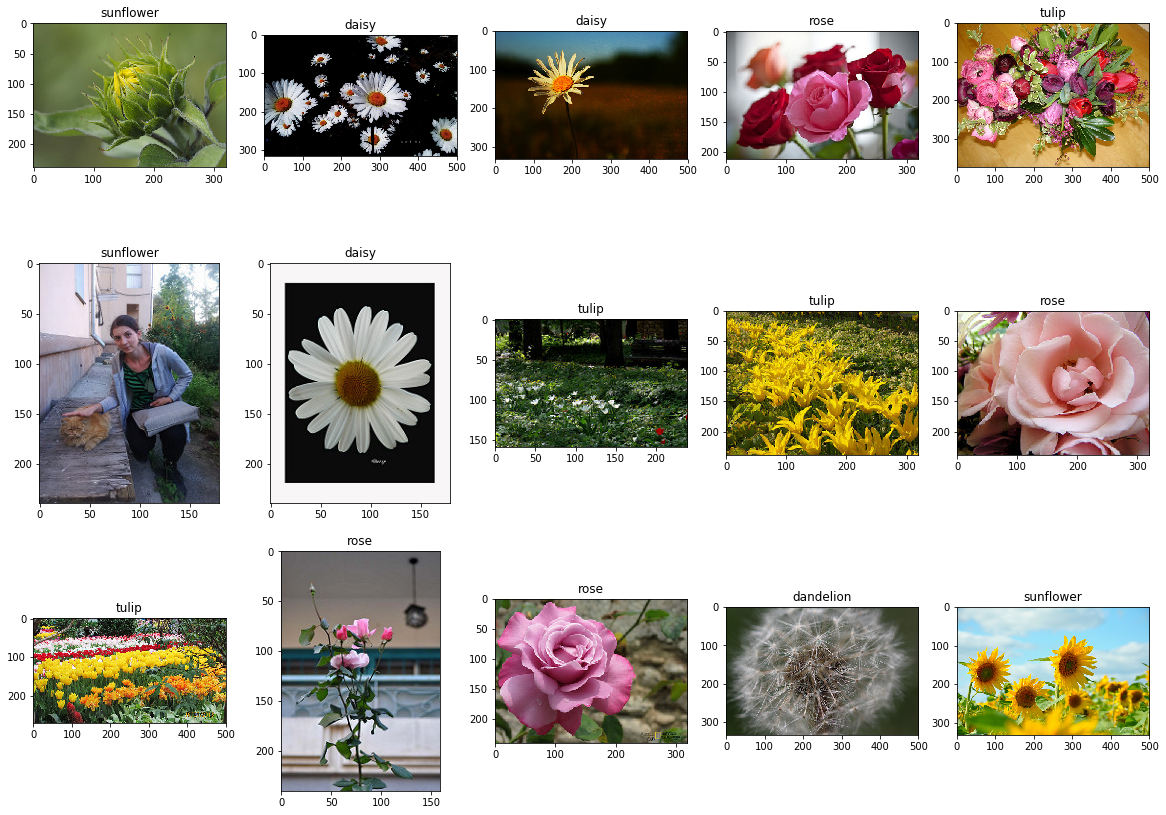

In [5]:
np.random.seed(random_seed)
n_samples = 15
sample_idx = np.random.choice(list(range(flowers_files.shape[0])), n_samples)
sample_files = flowers_files[sample_idx]
sample_titles = [flowers_target_names[i] for i in flowers_targets[sample_idx]]

plot_images(sample_files, sample_titles)

** Note: ** the flower pictures are of various sizes, angle of view, light conditions. We can also observe that some pictures have been artistically post-processed, adding colour filters altering the original colour of the flower. 
In some case the flower is not the main subject of the picture, as such we often have on the picture non-flower subjects such as insects, babies, wine bottle, etc. 

The Dandelion flower appear in 2 states: the yellow-orange flower and the whithe spherical seeds head "blowball" form.

<a id="step4"></a>
## 4. Flowers Classes distribution
[to the top](#top)

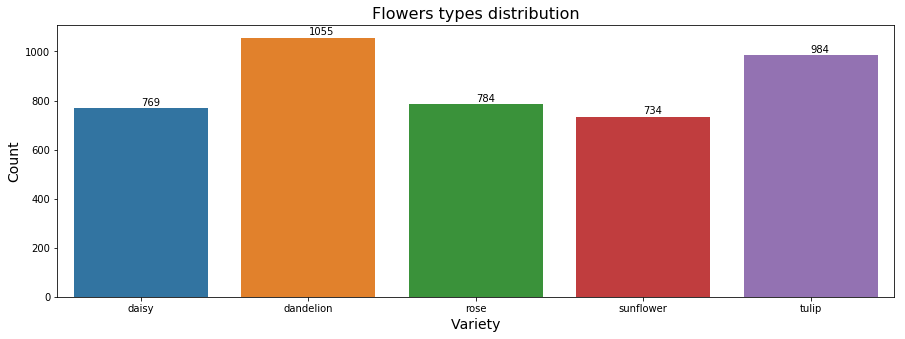

In [6]:
flowersDistBarplot(flowers_targets, flowers_target_names, "Flowers types distribution")

** Note : ** classes distribution is slightly unbalanced. 

[keras applications reference page](https://keras.io/applications/)

<a id="step5"></a>
## 5.1 stratified Train/Test split of the dataset
[to the top](#top)

** Note ** : stratified split is required to preserve a uniform distirbution of each class in both train and tests split

In [90]:
from sklearn.model_selection import train_test_split

test_size = .15

print("Splitting train/test flower files (split ratio: {} / {} %)...".format((1-test_size) * 100, test_size * 100))
flowers_files_train, flowers_files_test, flowers_targets_train, flowers_targets_test = train_test_split(
    flowers_files, flowers_targets, 
    test_size = test_size, 
    stratify=flowers_targets,
    random_state=random_seed)

print("{} training flowers files.".format(flowers_files_train.shape[0]))
print("{} testing flowers files.".format(flowers_files_test.shape[0]))

Splitting train/test flower files (split ratio: 85.0 / 15.0 %)...
3677 training flowers files.
649 testing flowers files.


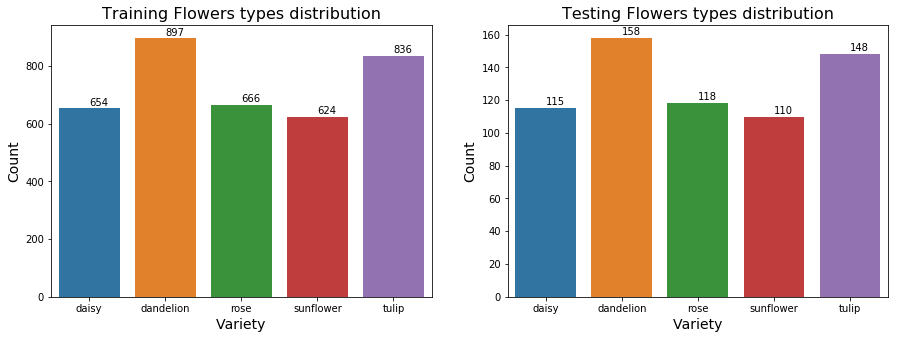

In [91]:
flowersDistBarplot([flowers_targets_train,flowers_targets_test],
                   flowers_target_names, 
                   ["Training Flowers types distribution", "Testing Flowers types distribution"])

## 5.2  copy flower pictures in train/test folders

In [124]:
# create data sub-directories

data_root = os.path.join('.','data')
subdirs = ['train', 'test']

if os.path.exists(data_root):
    print("Warning: {} folder already exist and will be overwritten".format(data_root))
    rmtree(data_root)
for d, t in itertools.product(subdirs, flowers_target_names):
    path = os.path.join(data_root, d, t)
    print("create new folder : {}".format(path))
    os.makedirs(path)

create new folder : .\data\train\daisy
create new folder : .\data\train\dandelion
create new folder : .\data\train\rose
create new folder : .\data\train\sunflower
create new folder : .\data\train\tulip
create new folder : .\data\test\daisy
create new folder : .\data\test\dandelion
create new folder : .\data\test\rose
create new folder : .\data\test\sunflower
create new folder : .\data\test\tulip


In [127]:
# copy pictures in data/ subdirectories
    
copy_pictures(flowers_files_train, 'train', data_root)
copy_pictures(flowers_files_test, 'test', data_root)

copying training images in ./data/train subdirectories...


100%|█████████████████████████████████████| 3677/3677 [00:17<00:00, 209.26it/s]


copying testing images in ./data/test subdirectories...


100%|████████████████████████████████████████| 649/649 [00:45<00:00, 14.37it/s]


<a id="step6"></a>
## 6. Data augmentation - Create image generators
[to the top](#top)

In [183]:
batch_size = 32 # default: 32

# train data generator - scaling and data augmentation for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        os.path.join('.', data_root, 'train'),  
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')

# test data generator - scaling only
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       os.path.join('.', data_root, 'test'),  
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical')

Found 3674 images belonging to 5 classes.
Found 649 images belonging to 5 classes.


<a id="step7"></a>
## 7. Build the model
[to the top](#top)

![Xception](https://i.imgur.com/tA2qDIQ.jpg)

In [188]:
# load the model (download the weights if necessary)
# include_top : whether to include the 3 fully-connected layers at the top of the network

#base_model_name = 'ResNet50'    # size: 99MB Top-5 Accuracy: 0.929
#base_model_name = 'InceptionV3' # size: 92MB Top-5 Accuracy: 0.944
base_model_name = 'Xception'    # size: 88MB Top-5 Accuracy: 0.945

base_model = Xception(weights='imagenet', include_top=False, input_shape=(150,150,3))


Predicted: [('n03991062', 'pot', 0.22630256), ('n12057211', "yellow_lady's_slipper", 0.18383509), ('n03930313', 'picket_fence', 0.067964949)]


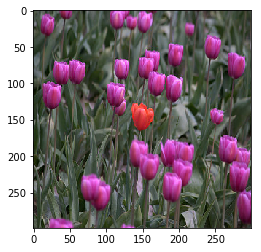

In [253]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

if "xception_model" not in locals():
    xception_model = Xception(weights='imagenet',include_top=True, input_shape=(299,299,3))

img = load_img(np.random.choice(flowers_files_test), target_size=(299, 299))

plt.imshow(img)

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = xception.preprocess_input(x)
preds = xception_model.predict(x)
print('Predicted:', xception.decode_predictions(preds, top=3)[0])

In [254]:
# freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False   
    
# new layers:
# -----------

x = Flatten()(base_model.output)
x = Dense(500, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax', name='fc2')(x)

# Model class API, take tensor in input and tensor in output
model = Model(inputs=base_model.input, outputs=x)

# Adam optimizer attributes:
# --------------------------
# lr: float >= 0. Learning rate.
# beta_1: float, 0 < beta < 1. Generally close to 1.
# beta_2: float, 0 < beta < 1. Generally close to 1.
# epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
# decay: float >= 0. Learning rate decay over each update.
# amsgrad: boolean. Whether to apply the AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and Beyond".

opt = Adam(lr = 1e-3, decay=1e-6)

model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 74, 74, 32)    864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 74, 74, 32)    128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 74, 74, 32)    0                                            
___________________________________________________________________________________________

<a id="step8"></a>
## 8. Train the Model
[to the top](#top)

In [256]:
dir(model.fit_generator)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__wrapped__',
 '_legacy_support_signature']

In [255]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.flowers_recognition.{}.hdf5'.format(base_model_name), 
                               verbose=1, save_best_only=True)

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=flowers_files_train.shape[0] // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps= flowers_files_test.shape[0] // batch_size,
    callbacks=[checkpointer], 
    verbose=1,
    use_multiprocessing=True
)

TypeError: fit_generator() got an unexpected keyword argument 'use_multiprocessing'

In [184]:
flowers_files_train.shape[0] // batch_size

114